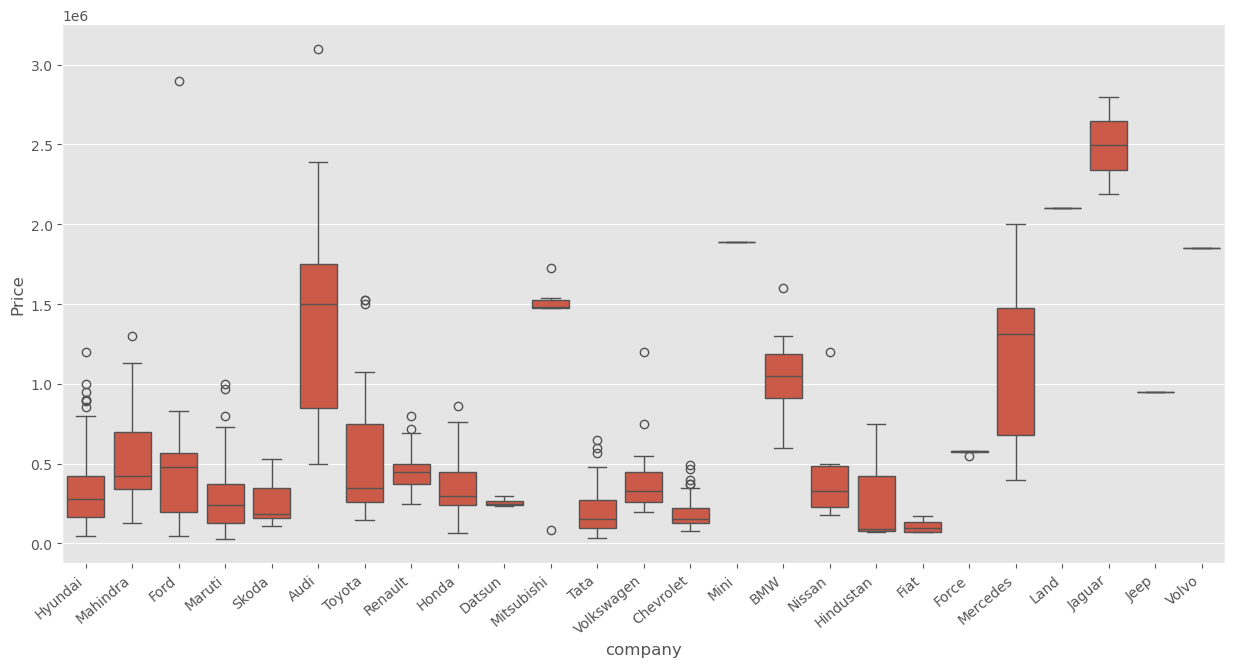

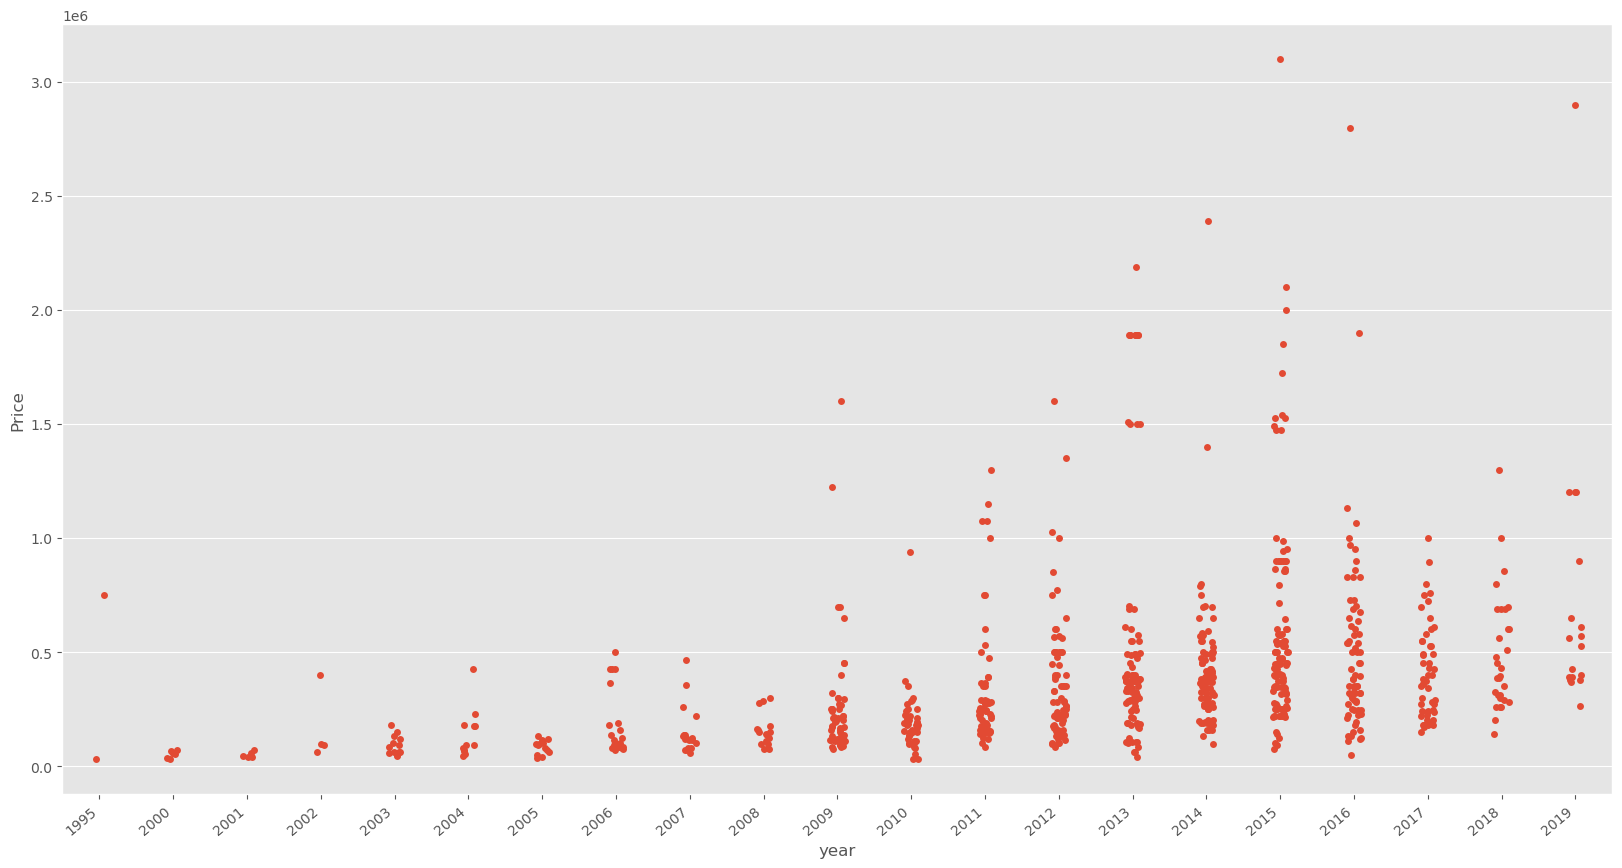

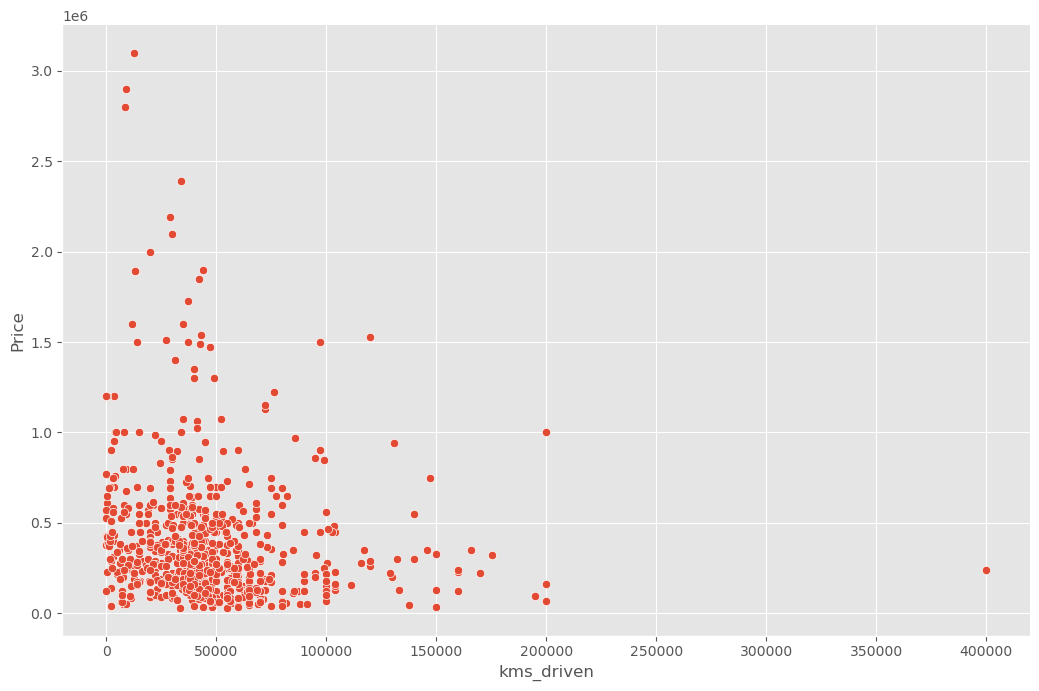

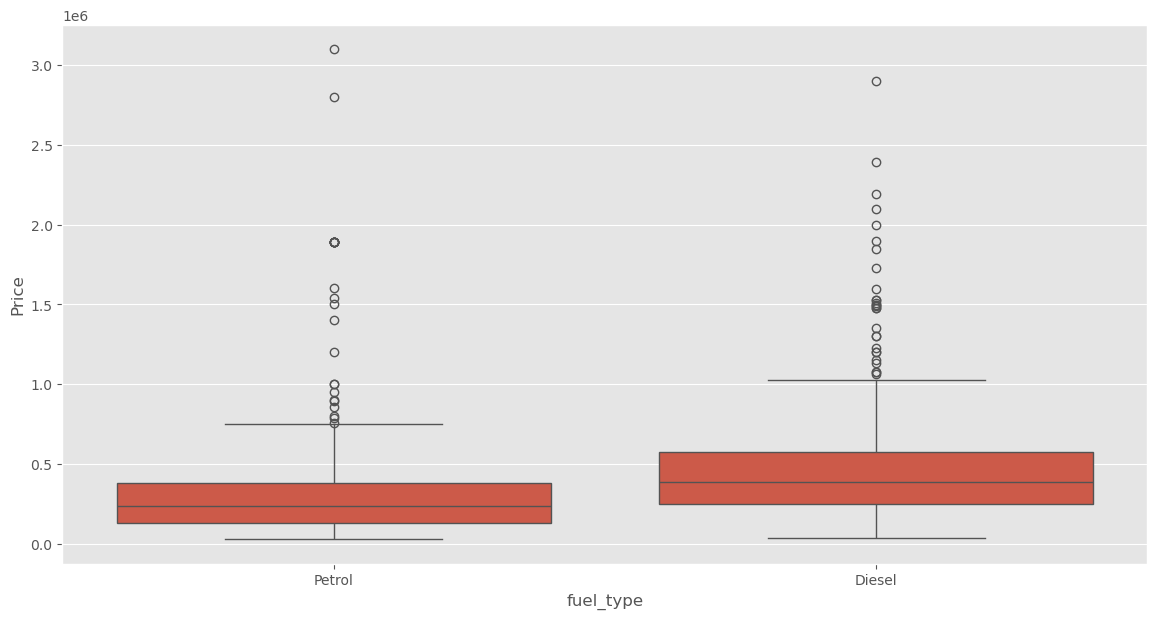

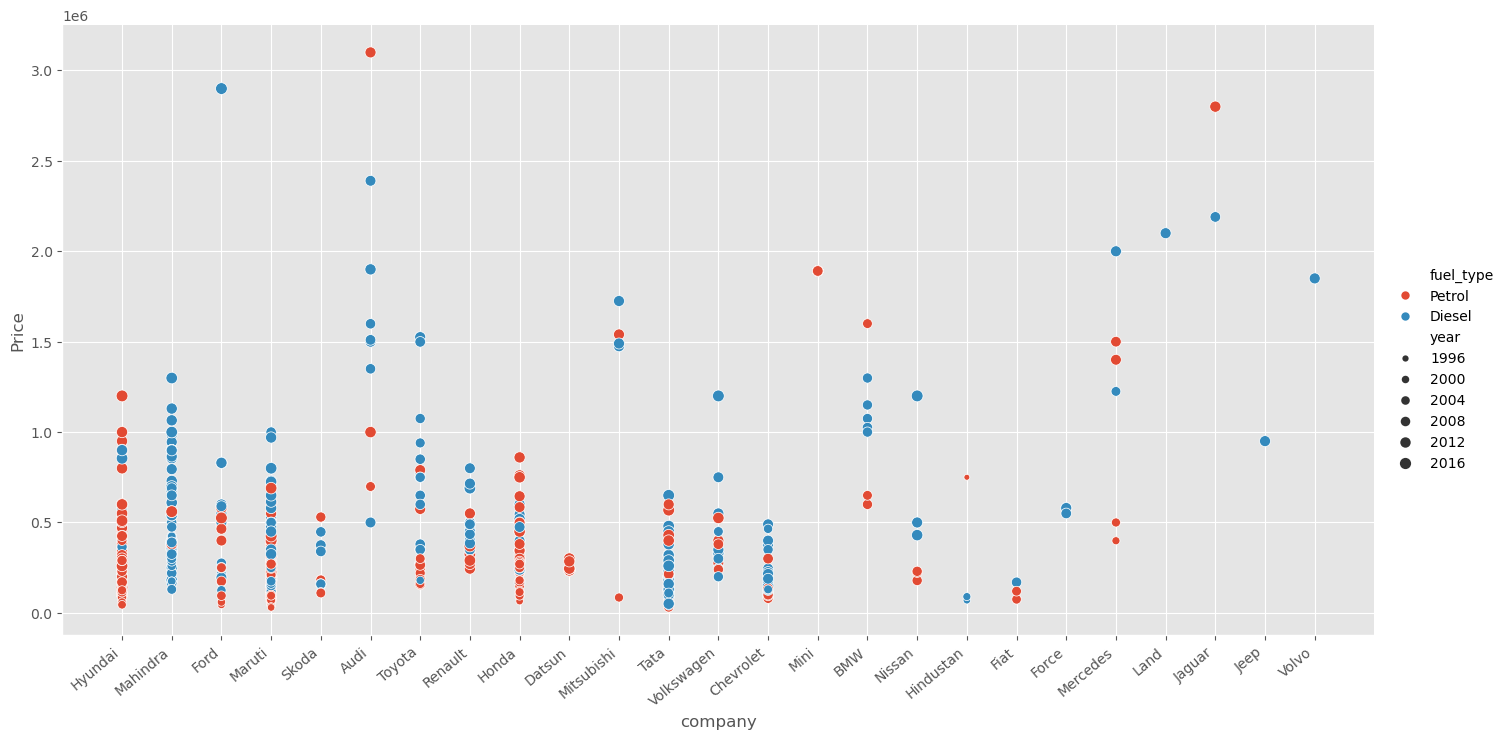

Best R2 Score: 0.8992694460662262
Best Random State: 302
Final R2 Score: 0.8992694460662262
Predicted Price: 455952.76494079083
Categories for 'name': ['Audi A3 Cabriolet' 'Audi A4 1.8' 'Audi A4 2.0' 'Audi A6 2.0' 'Audi A8'
 'Audi Q3 2.0' 'Audi Q5 2.0' 'Audi Q7' 'BMW 3 Series' 'BMW 5 Series'
 'BMW 7 Series' 'BMW X1' 'BMW X1 sDrive20d' 'BMW X1 xDrive20d'
 'Chevrolet Beat' 'Chevrolet Beat Diesel' 'Chevrolet Beat LS'
 'Chevrolet Beat LT' 'Chevrolet Beat PS' 'Chevrolet Cruze LTZ'
 'Chevrolet Enjoy' 'Chevrolet Enjoy 1.4' 'Chevrolet Sail 1.2'
 'Chevrolet Sail UVA' 'Chevrolet Spark' 'Chevrolet Spark 1.0'
 'Chevrolet Spark LS' 'Chevrolet Spark LT' 'Chevrolet Tavera LS'
 'Chevrolet Tavera Neo' 'Datsun GO T' 'Datsun Go Plus' 'Datsun Redi GO'
 'Fiat Linea Emotion' 'Fiat Petra ELX' 'Fiat Punto Emotion'
 'Force Motors Force' 'Force Motors One' 'Ford EcoSport'
 'Ford EcoSport Ambiente' 'Ford EcoSport Titanium' 'Ford EcoSport Trend'
 'Ford Endeavor 4x4' 'Ford Fiesta' 'Ford Fiesta SXi' 'Ford Figo'
 'F

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Plotting style
mpl.style.use('ggplot')

# Load dataset
car = pd.read_csv('quikr_car.csv')

# Backup copy
backup = car.copy()

# Data cleaning
car = car[car['year'].str.isnumeric()]
car['year'] = car['year'].astype(int)

car = car[car['Price'] != 'Ask For Price']
car['Price'] = car['Price'].str.replace(',', '').astype(int)

car['kms_driven'] = car['kms_driven'].str.split().str.get(0).str.replace(',', '')
car = car[car['kms_driven'].str.isnumeric()]
car['kms_driven'] = car['kms_driven'].astype(int)

car = car[~car['fuel_type'].isna()]

# Simplify car name
car['name'] = car['name'].str.split().str.slice(start=0, stop=3).str.join(' ')

# Reset index
car = car.reset_index(drop=True)

# Save cleaned data
car.to_csv('Cleaned_Car_data.csv', index=False)

# Filter out outliers
car = car[car['Price'] < 6000000]

# EDA Visualizations
plt.subplots(figsize=(15, 7))
ax = sns.boxplot(x='company', y='Price', data=car)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.show()

plt.subplots(figsize=(20, 10))
# Use stripplot instead of swarmplot to reduce crowding warnings
ax = sns.stripplot(x='year', y='Price', data=car, jitter=True)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.show()

sns.relplot(x='kms_driven', y='Price', data=car, height=7, aspect=1.5)
plt.show()

plt.subplots(figsize=(14, 7))
sns.boxplot(x='fuel_type', y='Price', data=car)
plt.show()

ax = sns.relplot(x='company', y='Price', data=car, hue='fuel_type', size='year', height=7, aspect=2)
for label in ax.ax.get_xticklabels():
    label.set_rotation(40)
    label.set_ha('right')
plt.show()

# Split data
X = car[['name', 'company', 'year', 'kms_driven', 'fuel_type']]
y = car['Price']

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Encoding & Modeling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

# Encoder setup
ohe = OneHotEncoder()
ohe.fit(X[['name', 'company', 'fuel_type']])

column_trans = make_column_transformer(
    (OneHotEncoder(categories=ohe.categories_), ['name', 'company', 'fuel_type']),
    remainder='passthrough'
)

lr = LinearRegression()
pipe = make_pipeline(column_trans, lr)

# Train model
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# Model stability testing
scores = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=i)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    scores.append(r2_score(y_test, y_pred))

best_random_state = np.argmax(scores)
print("Best R2 Score:", scores[best_random_state])
print("Best Random State:", best_random_state)

# Retrain with best model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=best_random_state)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Final R2 Score:", r2_score(y_test, y_pred))

# Save model
import pickle
pickle.dump(pipe, open('LinearRegressionModel.pkl', 'wb'))

# Predict new sample
sample = pd.DataFrame(columns=X.columns, data=[['Maruti Suzuki Swift', 'Maruti', 2019, 100, 'Petrol']])
sample['name'] = sample['name'].str.split().str.slice(start=0, stop=3).str.join(' ')
prediction = pipe.predict(sample)
print("Predicted Price:", prediction[0])

# Show categories for 'name'
# Access the fitted OneHotEncoder from the column transformer
ohe_fitted = pipe.named_steps['columntransformer'].transformers_[0][1]
print("Categories for 'name':", ohe_fitted.categories_[0])
